## Background Subtraction

* https://paper.dropbox.com/doc/Background-Subtraction-npiNWmoHieWisdICSjLJO

* Segmenting foreground objects from background
* Typically used to detect moving objects in video
* Use cases include surveillance, traffic monitoring, human pose estimation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

## Dataset

In [2]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIGSIZE = (6,6)

## Helpers

In [3]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

# Plotting Histogram (all channels flattened)
def plot_hist(img, bins=256, title=None):
    plt.hist(img.ravel(), bins=bins, range=[0,256])
    plt.title(title)
    plt.show()

def plot_bgr_hist(bgr_img, bins=256, mask=None):
    # Mask let's you select for certain regions    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([bgr_img],[i],mask,[bins],[0,256])
        plt.plot(histr, color=col)
        plt.xlim([0,bins])
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

In [4]:
metadata = pd.read_csv(metadata_fpath)
metadata['label_name'] = 'ball'
metadata['label_id'] = 1
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
ids = [fnames[i].strip('.png').split('_')[-1] for i in range(len(fnames))]
metadata['fpath'] = fpaths
metadata['id'] = ids
GT_BOXES = make_boxes(metadata)
metadata.sort_values(by='id', inplace=True)
fnames = metadata['filename']
metadata.head()

,filename,x1,x2,y1,y2,label_name,label_id,fpath,id
0,volleyball_frame_00665.png,45.5,64.5,175.0,195.0,ball,1,../data/volleyball/images_subset/volleyball_fr...,00665
1,volleyball_frame_00666.png,48.5,75.5,163.5,182.5,ball,1,../data/volleyball/images_subset/volleyball_fr...,00666
2,volleyball_frame_00669.png,59.0,89.0,126.5,161.5,ball,1,../data/volleyball/images_subset/volleyball_fr...,00669
3,volleyball_frame_00670.png,65.5,86.5,122.5,141.5,ball,1,../data/volleyball/images_subset/volleyball_fr...,00670
4,volleyball_frame_00672.png,74.5,95.5,109.0,131.0,ball,1,../data/volleyball/images_subset/volleyball_fr...,00672


## Animation

In [ ]:
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = plt.imread(fpaths[0])
imgplot = axes.imshow(img, animated=True)

all_boxes = GT_BOXES
def init():
    return (imgplot,)

def animate_w_boxes(fname):
    fpath = os.path.join(IMG_DIR, fname)
    img = plt.imread(fpath)
    imgplot.set_array(img)
    
    # Remove old boxes
    for p in axes.patches:
        p.remove()
    boxes = all_boxes[fname]
    for box in boxes:
        width = box['x2'] - box['x1']
        height = box['y2'] - box['y1']
        bb = Rectangle(
            (box['x1'],box['y1']), 
            width, height,
            fill=False,
            edgecolor="red")
        axes.add_patch(bb)    
    return (imgplot,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_w_boxes, init_func=init,
                               frames=fnames, interval=40, blit=True)

# ~1 minute to generate
HTML(anim.to_html5_video())

## Subtract Background

### Frame Differencing

In [159]:
# https://gist.github.com/TheSalarKhan/7c3d01ad13b0e7e5985a

def segment_bg(fpaths, subtractor, plot_mask=True):
    i = 0
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if plot_mask and i % 400 == 0:
            plot_img(fgmask, fs=FIGSIZE, title=fpath)    
        i+=1
    return subtractor.getBackgroundImage()

### Mixture of Gaussians

In [5]:
"""
# Based on "Improved adaptive Gausian mixture model for background subtraction"
# and "Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction"
# Automatically selects the appropriate number of gaussian distributions for each pixel

history = # of previous frames to include in calculation
threshold = How sensitive the background is to movement/change
    * higher threshold will capture only large movements/changes. 
    * lower threshold will capture more subtle movements/ slight changes)
""";

def segment_mog(fpaths, subtractor, plot_mask=True):
    i = 0
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if plot_mask and i > 0 and i % 500 == 0:
            plot_img(fgmask, fs=FIGSIZE, title=fpath)    
        i+=1
    return subtractor.getBackgroundImage()

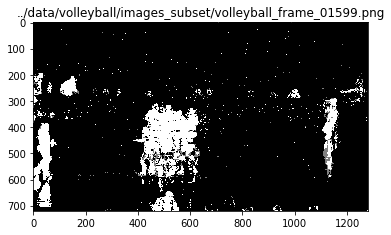

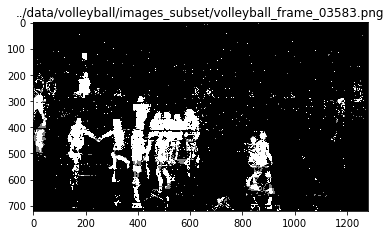

In [161]:
mog_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=300, 
    varThreshold=10, 
    detectShadows=True
)
bg_img = segment_mog(metadata['fpath'], mog_subtractor, plot_mask=True)

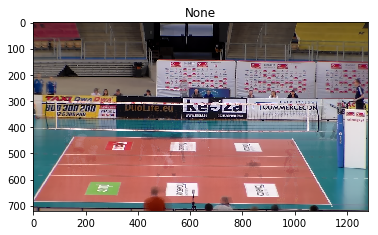

In [162]:
plot_img(bg_img, fs=FIGSIZE)

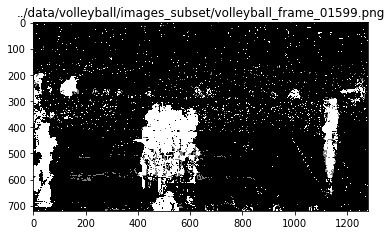

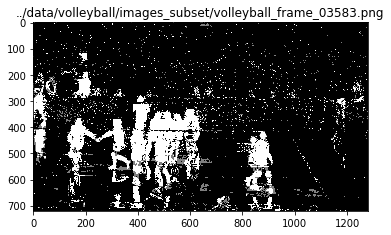

In [163]:
mog_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=200, 
    varThreshold=5, 
    detectShadows=True
)
bg_img = segment_mog(metadata['fpath'], mog_subtractor, plot_mask=True)

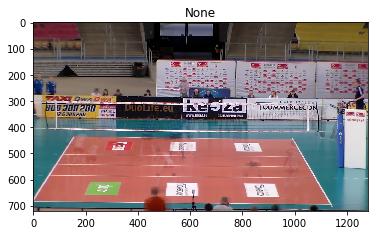

In [164]:
plot_img(bg_img, fs=FIGSIZE)

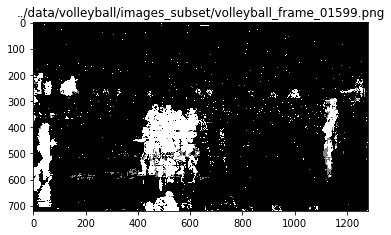

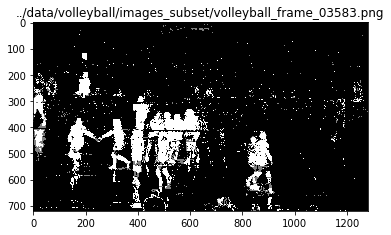

In [165]:
# Longer history
#   * Pro: Captures flickering/oscillating background objects 
#   * Con: Risks capturing players who move, but stay in the same area
mog_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=1000, 
    varThreshold=10, 
    detectShadows=True
)
bg_img = segment_mog(metadata['fpath'], mog_subtractor, plot_mask=True)

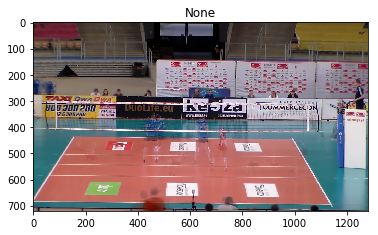

In [166]:
plot_img(bg_img, fs=FIGSIZE)

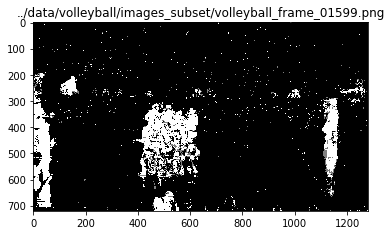

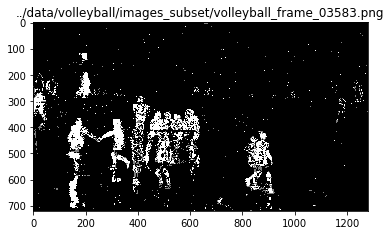

In [167]:
# Shorter history
#   * Pro: Captures foreground objects that move quickly / abruptly
#   * Con: Picks up background noise for small moving items in the background

mog_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=50, 
    varThreshold=10, 
    detectShadows=True
)
bg_img = segment_mog(metadata['fpath'], mog_subtractor, plot_mask=True)

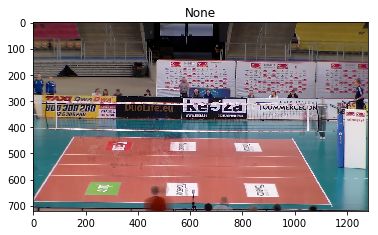

In [168]:
plot_img(bg_img, fs=FIGSIZE)

### KNN Subtractor

In [170]:
def segment_knn(fpaths, subtractor, kernel, plot_mask=True):
    i = 0
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        #fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        if plot_mask and i > 0 and i % 500 == 0:
            plot_img(fgmask, fs=FIGSIZE, title=fpath)    
        i+=1
    return subtractor.getBackgroundImage()

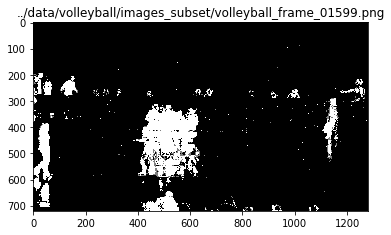

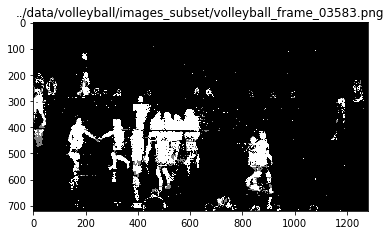

In [171]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
knn_subtractor = cv2.createBackgroundSubtractorKNN()
bg_img = segment_knn(metadata['fpath'], knn_subtractor, kernel, plot_mask=True)

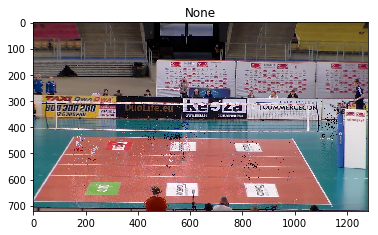

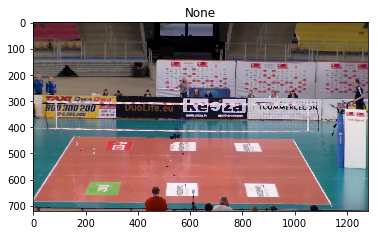

In [172]:
# Median Filter
# Clears out the Salt and pepper noise
# https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
plot_img(bg_img, fs=FIGSIZE)
median = cv2.medianBlur(bg_img, 5)
plot_img(median, fs=FIGSIZE)

## Apply Background Mask

In [173]:
import copy
def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

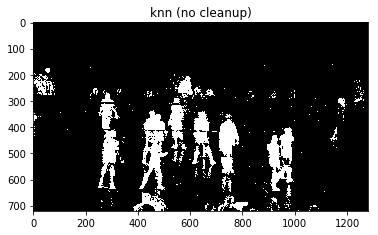

In [174]:
plot_limit = 1
knn_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=50)
for m in knn_masks[:plot_limit]:
    plot_img(m, title='knn (no cleanup)')

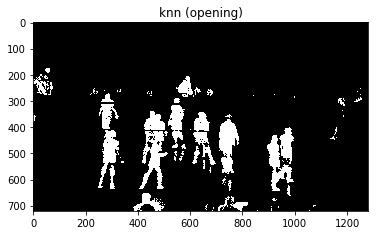

In [175]:
knn_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=50, cleanup='open')
for m in knn_masks[:plot_limit]:
    plot_img(m, title='knn (opening)')

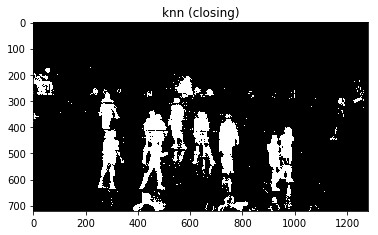

In [176]:
knn_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=50, cleanup='close')
for m in knn_masks[:plot_limit]:
    plot_img(m, title='knn (closing)')

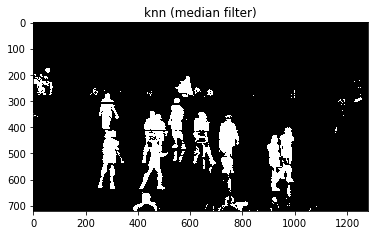

In [177]:
knn_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=5000, cleanup='median')
for m in knn_masks[:plot_limit]:
    plot_img(m, title='knn (median filter)')

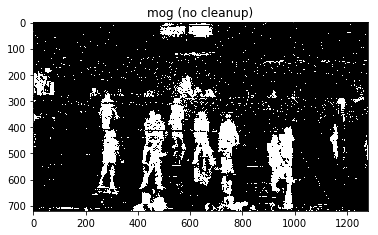

In [178]:
mog_masks = apply_bg_mask(metadata['fpath'], mog_subtractor, limit=50)
for m in mog_masks[:plot_limit]:
    plot_img(m, title='mog (no cleanup)')

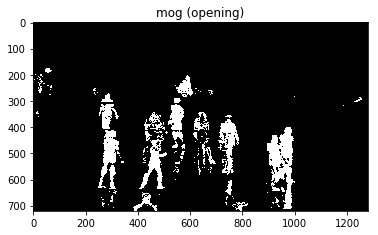

In [179]:
mog_masks = apply_bg_mask(metadata['fpath'], mog_subtractor, limit=50, cleanup='open')
for m in mog_masks[:plot_limit]:
    plot_img(m, fs=FIGSIZE, title='mog (opening)')

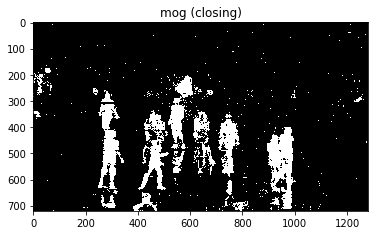

In [180]:
mog_masks = apply_bg_mask(metadata['fpath'], mog_subtractor, limit=50, cleanup='close')
for m in mog_masks[:plot_limit]:
    plot_img(m, title='mog (closing)')

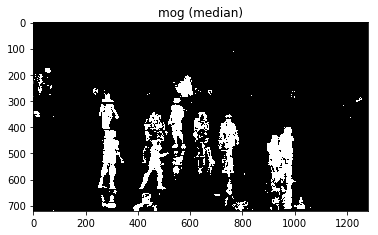

In [181]:
mog_masks = apply_bg_mask(metadata['fpath'], mog_subtractor, limit=50, cleanup='median')
for m in mog_masks[:plot_limit]:
    plot_img(m, title='mog (median)')

## Ensemble Masks

In [193]:
def ensemble_masks(mask_arrays, cleanup=None):
    base_group = copy.deepcopy(mask_arrays[0])
    for mask_group in mask_arrays[1:]:
        for i in range(len(mask_group)):
            base_group[i] = (base_group[i] + mask_group[i]) // len(mask_arrays)
    if cleanup:
        for i,mask in enumerate(base_group):
            if cleanup == 'open':
                base_group[i] = opening(mask)
            elif cleanup == 'close':
                base_group[i] = closing(mask)
            elif cleanup == 'median':
                base_group[i] = median_filter(mask)
            base_group[i][base_group[i] >= 2] = 255
            base_group[i][base_group[i] < 2] = 0
    return base_group

In [190]:
limit = 200
knn_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=limit)#, cleanup='open')
mog_masks = apply_bg_mask(metadata['fpath'], mog_subtractor, limit=limit)#, cleanup='open')
mask_groups = [knn_masks, mog_masks]
plot_limit = 1

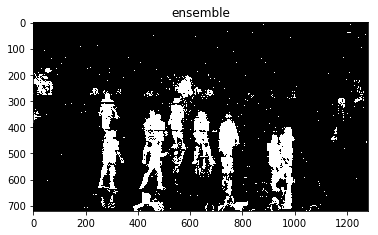

In [191]:
ensemble = ensemble_masks(mask_groups)
for m in ensemble[:plot_limit]:
    plot_img(m, title='ensemble')

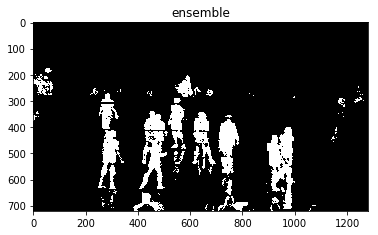

In [194]:
ensemble_open = ensemble_masks(mask_groups, cleanup='open')
for m in ensemble_open[:plot_limit]:
    plot_img(m, title='ensemble')

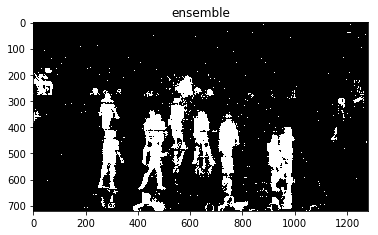

In [195]:
ensemble_close = ensemble_masks(mask_groups, cleanup='close')
for m in ensemble_close[:plot_limit]:
    plot_img(m, title='ensemble')

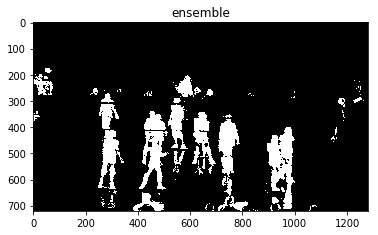

In [196]:
ensemble_median = ensemble_masks(mask_groups, cleanup='median')
for m in ensemble_median[:plot_limit]:
    plot_img(m, title='ensemble')

## Segment Players

In [197]:
frames = ensemble_median
img_fpaths = metadata['fpath']

In [ ]:
# Animate Masks
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = frames[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=40, blit=True)

# ~1 minute to generate
HTML(anim.to_html5_video())

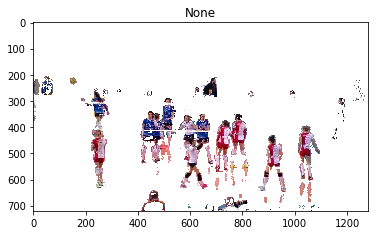

In [205]:
def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

masked_frames = get_masked_imgs(metadata['fpath'], frames)
plot_img(masked_frames[10])

In [ ]:
# Animate Masked Images
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = masked_frames[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=masked_frames, interval=40, blit=True)

# ~1 minute to generate
HTML(anim.to_html5_video())

## Save Video

* https://github.com/ContinuumIO/anaconda-issues/issues/223
* https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook
* https://stackoverflow.com/questions/4129674/does-html5-video-playback-support-the-avi-format

In [ ]:
from pathlib import Path
frames = masked_frames
frame1 = frames[0]

scale = .4
height, width, _ = frame1.shape
height = int(height * scale)
width = int(width * scale)
print(height, width)

outdir = Path(DATA_DIR, 'back_subtract')
outdir.mkdir(exist_ok=True)
outfpath = str(Path(outdir, 'image_mask.avi'))

In [ ]:
writer = cv2.VideoWriter(outfpath, cv2.VideoWriter_fourcc(*"MJPG"), 20, (width, height))

for frame in frames:
    frame = cv2.resize(frame, (width, height), interpolation = cv2.INTER_CUBIC)
    writer.write(frame.astype('uint8'))

writer.release()

In [154]:
# Won't work with AVI files (but OpenCV only writes to AVI?)
# %%HTML
# <video width="800" height="500" controls>
#   <source src="../data/back_subtract/image_mask.avi" type="video/avi">
# </video>

## bgslibrary

* https://github.com/andrewssobral/bgslibrary
* https://www.researchgate.net/publication/259340906_A_comprehensive_review_of_background_subtraction_algorithms_evaluated_with_synthetic_and_real_videos

## Sources

* https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html
* https://gist.github.com/TheSalarKhan/7c3d01ad13b0e7e5985a
* https://en.wikipedia.org/wiki/Background_subtraction
* https://en.wikipedia.org/wiki/Foreground_detection
* https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/
* https://www.cs.utexas.edu/~grauman/courses/fall2009/slides/lecture9_background.pdf 
* https://hal.inria.fr/inria-00545478/document
* https://arxiv.org/pdf/1707.03166.pdf
* https://arxiv.org/pdf/1505.02921.pdf
* https://www.deepdyve.com/lp/elsevier/a-comprehensive-review-of-background-subtraction-algorithms-evaluated-bZ0jpkRh44?key=elsevier
* https://github.com/andrewssobral/bgslibrary/wiki/Which-algorithms-really-matter%3F
* https://docs.opencv.org/3.2.0/d1/dc5/tutorial_background_subtraction.html
* https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
* http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html
* http://tommesani.com/index.php/video/comparing-background-subtraction-algorithms.html
* https://www.researchgate.net/publication/259340906_A_comprehensive_review_of_background_subtraction_algorithms_evaluated_with_synthetic_and_real_videos

## Datasets

* ChangeDetection.net (For more information: http://www.changedetection.net/)
* Background Models Challenge (For more information: http://bmc.iut-auvergne.com/)
* Stuttgart Artificial Background Subtraction Dataset (For more information: http://www.vis.uni-stuttgart.de/index.php?id=sabs)
* SBMI dataset (For more information: http://sbmi2015.na.icar.cnr.it/)
* SBMnet dataset (For more information: http://pione.dinf.usherbrooke.ca/dataset/)